In [1]:
%reload_ext autoreload
%autoreload 2
# !pip install --upgrade transformers 
# which python
# !pip install -q transformers
# !pip install -q datasets
# !pip install -q evaluate
# !pip install -q accelerate
# !pip install -q gluonts ujson

# Tutoial directly gotten from https://huggingface.co/blog/time-series-transformers


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

df = pd.read_csv("../../datasets/electric_clean.txt", sep=';')
print("Length of dataset", len(df))
print(df.head())


Length of dataset 140256
                    dt  MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  \
0  2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0   
1  2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0   
2  2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0   
3  2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0   
4  2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_007  MT_008  MT_009  ...  MT_361  MT_362  MT_363  MT_364  MT_365  \
0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   

   MT_366  MT_367  MT_368  MT_369  MT_370  
0     0.0     0.0     0.0     0.0     0.0

In [3]:
# df = df.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
# df = df.astype(float)
# df.to_csv('../../datasets/electric_clean.txt', index=True,sep=';')

df.set_index('dt', inplace=True)
print(df.head())
print(df.info())
df.index = pd.to_datetime(df.index)

# df.index.name

                     MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
dt                                                                            
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010  ...  MT_361  MT_362  MT_363  \
dt                                           ...                           
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0  ...     0.0     0.0  

In [107]:
# here we split the data into different granularity (hours, days, weeks, months)
df_days = df.resample("D").mean()
# # print(df_days.shape)
df_days
# df_days.to_csv('../../datasets/electric_clean.txt', sep=';', index=True)


In [5]:
# Replace all 0.0s with NaN, this is needed for the observed mask that will be passed into the transformer
import numpy as np
print(np.isnan(df_days.iloc[0, 0]))
df_days = df_days.replace(0.0, np.nan)
print(np.isnan(df_days.iloc[0, 0]))
df_days


False
True


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
dt,,,,,,,,,,,,,,,,,,,,,
2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,2.366223,22.203947,1.574718,149.242039,70.591972,209.604415,4.475221,263.082211,53.321678,49.943996,...,300.157626,34084.375000,2299.182489,2682.054924,85.098870,5.753852,478.279558,45.892460,688.912818,16179.054054
2014-12-29,2.590948,23.048542,1.674269,146.532012,74.987297,237.754216,5.735350,315.481201,69.766171,66.017025,...,300.261718,32386.458333,2154.711674,2803.030303,87.896567,12.019700,561.759219,134.529772,769.611437,18817.567568
2014-12-30,2.419099,22.974455,1.719519,148.860942,74.885671,248.759921,6.112210,321.969697,67.580857,67.596326,...,296.752320,30253.125000,2126.318565,2745.975379,110.576923,9.295153,586.817749,166.631886,770.314027,19453.828829


In [6]:
# num_of_datapoints = 500
# df_days = df_days.iloc[:num_of_datapoints, :50] # only use a 500 time point and 50 houses

num_of_datapoints = 500
df_days = df_days.iloc[:num_of_datapoints, 155:165] # only use a 500 time point and 50 houses
df_days


,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165
dt,,,,,,,,,,
2011-01-01,68.301868,NaN,34.112722,16.847247,NaN,1910.298895,165.686220,1951.006549,NaN,NaN
2011-01-02,68.300842,NaN,34.519691,16.734215,NaN,1989.036780,162.314422,2454.421083,NaN,NaN
2011-01-03,68.307340,NaN,91.744374,109.760137,NaN,2138.760288,382.445210,2695.852535,NaN,NaN
2011-01-04,68.300842,NaN,108.332359,110.838921,NaN,2231.674383,429.369919,2832.253264,NaN,NaN
2011-01-05,68.300842,NaN,101.581161,119.786079,NaN,2224.633488,421.041004,2679.555492,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2012-05-10,82.596694,2134.816282,85.346340,43.682651,NaN,1881.397891,348.356310,2339.885753,132.998649,NaN
2012-05-11,82.596694,2161.533381,95.773591,49.234415,NaN,1985.564558,361.269441,2366.047427,137.435520,NaN
2012-05-12,82.590195,1953.950528,25.459977,21.375818,NaN,1845.743313,287.071403,2347.686252,122.374724,NaN


In [7]:
from gluonts.dataset.common import ListDataset
# Data splitting 
from gluonts.dataset.field_names import FieldName
from sklearn.preprocessing import MinMaxScaler
# Choosing prediction column 
# n_cols = 1
# For now I am only using Global_active_power to predict Global_active_power (days)
# dataset = df["Global_active_power"]
# dataset = df_days["Global_active_power"]
# dataset = df_hours["Global_active_power"]
# dataset = pd.DataFrame(dataset)

# All the hyperparameters here including the patch sizes are the same as delhi.ipynb just to keep things consistent
scaler = MinMaxScaler(feature_range= (0, 1))
df_scaled = df_days.apply(lambda x: pd.Series(scaler.fit_transform(x.values.reshape(-1, 1)).flatten()), axis=0)

train_ds = []
test_ds = []
val_ds = []
train_size = int(num_of_datapoints * 0.5)
val_size = int(0.75 * num_of_datapoints) - train_size
for column_name in df_scaled.columns:
    print(column_name)
    # access the current column
    data = df_scaled[column_name]
    
    data = np.array(data)
    data = data.reshape(data.shape[0])
    # Get train, val, and test data
    train_data = data[0:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    
    prediction_length = 7 # 7 days 
    freq = "1D" # set frequency to 1 day
    # target, feat_dynamic_real, feat_static_cat = data_out
    def getTarget(patch, stride, data_list):
        
        target = []
        for i in range(patch, len(data_list), stride):
            target.append(data_list[i-patch:i])
        # Convert to numpy array
        target = np.array(target)
        # Reshaping the input to (n_samples, time_steps, n_feature)
        # target = np.reshape(target, (target.shape[0], target.shape[1], n_cols))
        return target
    # TODO: why is the start date not changing? MIGHT NEED TO FIX
    train_target = getTarget(28, 1, train_data)
    feat_static_cat = [i for i in range(len(train_target))]
    train_start =  [pd.Period("01-01-2011", freq=freq) for _ in range(len(train_target))]
    train_ds.extend(ListDataset(
        [
            {
                FieldName.TARGET: target,
                FieldName.START: start,
                FieldName.FEAT_STATIC_CAT: [fsc],
            }
            for (target, start, fsc) in zip(
                train_target[:, :-prediction_length],
                train_start,
                feat_static_cat,
            )
        ],
        freq=freq,
    ))

    val_target = getTarget(28, 1, val_data)
    val_start =  [pd.Period("08-09-2011", freq=freq) for _ in range(len(val_target))]
    val_ds.extend(ListDataset(
        [
            {
                FieldName.TARGET: target,
                FieldName.START: start,
                FieldName.FEAT_STATIC_CAT: [fsc],
            }
            for (target, start, fsc) in zip(
                val_target[:, :-prediction_length],
                val_start,
                feat_static_cat,
            )
        ],
        freq=freq,
    ))


    test_target = getTarget(28, 1, test_data)
    test_start =  [pd.Period("01-11-2012", freq=freq) for _ in range(len(test_target))] 
    test_ds.extend(ListDataset(
        [
            {
                FieldName.TARGET: target,
                FieldName.START: start,
                FieldName.FEAT_STATIC_CAT: [fsc],
            }
            for (target, start, fsc) in zip(
                test_target[:, :-prediction_length],
                test_start,
                feat_static_cat,
            )
        ],
        freq=freq,
    ))

c:\Python310\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Python310\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
c:\Python310\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Python310\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


MT_156
MT_157
MT_158
MT_159
MT_160
MT_161
MT_162
MT_163
MT_164
MT_165


In [108]:
print(train_ds)
print(len(train_ds)) # 2440 

[{'target': array([0.16516869, 0.16513051, 0.1653723 , 0.16513051, 0.16513051,
       0.1653723 , 0.16513051, 0.10823815, 0.10799878, 0.10775458,
       0.10775458, 0.10775458, 0.10775458, 0.10775458, 0.10799878,
       0.10775458, 0.10775458, 0.10775458, 0.10775458, 0.10799878,
       0.10775458], dtype=float32), 'start': Period('2011-01-01', 'D'), 'feat_static_cat': array([0])}, {'target': array([0.16513051, 0.1653723 , 0.16513051, 0.16513051, 0.1653723 ,
       0.16513051, 0.10823815, 0.10799878, 0.10775458, 0.10775458,
       0.10775458, 0.10775458, 0.10775458, 0.10799878, 0.10775458,
       0.10775458, 0.10775458, 0.10775458, 0.10799878, 0.10775458,
       0.10775458], dtype=float32), 'start': Period('2011-01-01', 'D'), 'feat_static_cat': array([1])}, {'target': array([0.1653723 , 0.16513051, 0.16513051, 0.1653723 , 0.16513051,
       0.10823815, 0.10799878, 0.10775458, 0.10775458, 0.10775458,
       0.10775458, 0.10775458, 0.10799878, 0.10775458, 0.10775458,
       0.10775458, 0.

In [9]:
train_dataset = train_ds
val_dataset = val_ds
test_dataset = test_ds

    
freq = "1D"


In [10]:
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str

# The look back window, in this case how many days we consider 
# lags_sequence = get_lags_for_frequency(freq)
lags_sequence = get_lags_for_frequency(freq)[:19]
time_features = time_features_from_frequency_str(freq)

print(lags_sequence)
print(time_features)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31]
[<function day_of_week at 0x000002EE12201E10>, <function day_of_month at 0x000002EE12201F30>, <function day_of_year at 0x000002EE12202050>]


In [11]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # # How many inputs the model take into account when 
    context_length=prediction_length * 2, 
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,# TODO: understand this 
    # day of year, day of months, and day of week
    num_time_features=len(time_features),
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],# TODO: understand this 
    scaling = "std",
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32, 
    num_parallel_samples = 1 # default
    
)

model = TimeSeriesTransformerForPrediction(config)

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # We use days of week, days of months, and days of years in this case 
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            # AddAgeFeature(
            #     target_field=FieldName.TARGET,
            #     output_field=FieldName.FEAT_AGE,
            #     pred_length=config.prediction_length,
            #     log_scale=True,
            # ),
            # # step 6: vertically stack all the temporal features into the key FEAT_TIME
            # VstackFeatures(
            #     output_field=FieldName.FEAT_TIME,
            #     input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
            #     + (
            #         [FieldName.FEAT_DYNAMIC_REAL]
            #         if config.num_dynamic_real_features > 0
            #         else []
            #     ),
            # ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )
    
    
    
# transformation = create_transformation(freq, config)
# transformed_data = transformation.apply(train_dataset, is_train=False)
# print(next(iter(transformed_data))["time_features"].shape)
# print(train_dataset[0].keys())

# print(next(iter(transformed_data))["time_features"][0])
# # print(train_dataset[0]["target"])
# time_features_from_frequency_str(freq)[0](train_dataset[0]["start"])

In [13]:


from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches

def create_dataloader(
    type_ : str, 
    is_train: bool,
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=is_train)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, type_)

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=is_train
    )
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )
    
    
    
    
    
def create_val_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a val Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [14]:
train_dataloader = create_dataloader(
    "train",
    True,
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

val_dataloader1 = create_dataloader(
    "validation",
    False,
    config=config,
    freq=freq,
    data=val_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader1 = create_dataloader(
    "test",
    False,
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [15]:

batch = next(iter(train_dataloader))
# perform forward pass
print(batch.keys())
# dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])
# dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])

model.eval()
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)
print("Loss:", outputs.loss.item())


dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])
Loss: -2.1879727840423584


In [16]:
from accelerate import Accelerator
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler
from evaluate import load
from gluonts.time_feature import get_seasonality
from IPython.display import clear_output
import os 

accelerator = Accelerator()
device = accelerator.device

def train(model, train_data_loader, val_data_loader, 
          epoch, lr, weight_decay, encoder_layers, decoder_layers, d_model, path_prefix=None):
    model.to(device)
    # path_prefix = f"saved_models/{str(lr)}-{str(weight_decay)}-{str(encoder_layers)}-{str(decoder_layers)}-{str(d_model)}/"
    if not path_prefix: 
        path_prefix = f"saved_models/electric/7/vanilla/{str(lr)}-{str(weight_decay)}-{str(encoder_layers)}-{str(decoder_layers)}-{str(d_model)}/"
    # Check if the folder exists, and create it if it doesn't
    if not os.path.exists(path_prefix + "state/"):
        print("creating new path " + path_prefix + "state/")
        os.makedirs(path_prefix + "state/")
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=weight_decay)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    model, optimizer, train_data_loader, val_data_loader = accelerator.prepare(
        model,
        optimizer,
        train_data_loader,
        val_data_loader
    )
    model.train()
    best_train_score = float("infinity")
    best_train_epoch = -1
    best_val_score = float("infinity")
    best_val_epoch = -1 
    print("-------------TRAINING START-------------")
    print("Training with epoch: " + str(epoch))
    train_losses, val_losses, test_losses = [], [], []  
    epoch_list = []
    for ep in range(epoch):
        model.train()
        curLoss, i = 0, 0
        for idx, batch in enumerate(train_data_loader):
            optimizer.zero_grad()
            outputs = model(
                static_categorical_features=batch["static_categorical_features"].to(device)
                if config.num_static_categorical_features > 0
                else None,
                static_real_features=batch["static_real_features"].to(device)
                if config.num_static_real_features > 0
                else None,
                past_time_features=batch["past_time_features"].to(device),
                past_values=batch["past_values"].to(device),
                future_time_features=batch["future_time_features"].to(device),
                future_values=batch["future_values"].to(device),
                past_observed_mask=batch["past_observed_mask"].to(device),
                future_observed_mask=batch["future_observed_mask"].to(device),
            )
            loss = outputs.loss
            curLoss += loss.item()
            # Backpropagation
            accelerator.backward(loss)
            optimizer.step()
            i += 1 
            if idx % 100 == 0:
                print(loss.item())
        train_losses.append(curLoss / i)
        if train_losses[-1] < best_train_score:
            best_train_score = train_losses[-1]
            best_train_epoch = ep 
        scheduler.step()
        
        model.eval()
        with torch.no_grad():
            
            curLoss, i = 0, 0
            for idx, batch in enumerate(val_data_loader):
                optimizer.zero_grad()
                outputs = model(
                    static_categorical_features=batch["static_categorical_features"].to(device)
                    if config.num_static_categorical_features > 0
                    else None,
                    static_real_features=batch["static_real_features"].to(device)
                    if config.num_static_real_features > 0
                    else None,
                    past_time_features=batch["past_time_features"].to(device),
                    past_values=batch["past_values"].to(device),
                    future_time_features=batch["future_time_features"].to(device),
                    future_values=batch["future_values"].to(device),
                    past_observed_mask=batch["past_observed_mask"].to(device),
                    future_observed_mask=batch["future_observed_mask"].to(device),
                )
                loss = outputs.loss
                i += 1
                curLoss += loss.item()
            val_losses.append(curLoss / i)
            if val_losses[-1] < best_val_score:
                best_val_score = val_losses[-1]
                best_val_epoch = ep 
            
        # Here we plot the graphs
        
        clear_output(wait=True)
        epoch_list.append(ep)
        plt.plot(epoch_list, train_losses, label='Train', color='Green')
        plt.plot(epoch_list, val_losses, label='Val', color='Yellow')

        # Add labels and a legend
        plt.xlabel('Epoch')
        plt.ylabel('losses')
        plt.legend()
 
        plt.draw()
        # Pause to refresh the plot
        if ep == epoch - 1:
            plt.savefig(path_prefix + "graph.png")
        plt.pause(0.1)  # Adjust the duration as needed
        plt.clf()
        # Show the plot
        plt.show()
        # log the corresponding losses at each epochs 
        with open(path_prefix + "log.txt", "a") as f:
            f.write(f"Epoch {str(ep)} | Train Loss : {str(train_losses[-1])} | Val Loss : {str(val_losses[-1])}\n")
        
        # Save the model's state at each ep
        PATH = path_prefix + "state/" + str(ep)
        torch.save(model.state_dict(), PATH)

    # Log the best results
    with open(path_prefix + "log.txt", "a") as f:
        f.write(f"Best Train Loss | {str(best_train_score)} | Epoch {str(best_train_epoch)}\n")
        f.write(f"Best Val Loss | {str(best_val_score)} | Epoch {str(best_val_epoch)}\n")
    
    # Plot the graph 
    print("-------------TRAINING END-------------")
    return model, best_train_score, best_train_epoch, best_val_score, best_val_epoch
    

In [17]:

# model = TimeSeriesTransformerForPrediction(config)
# model = train(model, train_dataloader, val_dataloader1, test_dataloader1, 10)

In [18]:
import random 
from scipy.stats import uniform, loguniform
from transformers import AutoformerConfig, AutoformerForPrediction
from transformers import InformerConfig, InformerForPrediction

# Grid search the best parameters
def getParameterPairs(numOfSearch):
    parameter_pairs = []
    high_lr = 0.01
    low_lr =  0.0000001

    high_wd = 0.01
    low_wd = 0.0001 
    encoder_layers_range = [4, 8, 16]
    decoder_layers_range = [4, 8, 16]
    d_model_range = [32, 64, 128]
    for _ in range(numOfSearch):
        lr = loguniform(low_lr, high_lr).rvs(1)[0]
        wd = loguniform(low_wd, high_wd).rvs(1)[0]
        el = random.choice(encoder_layers_range)
        dl = random.choice(decoder_layers_range)
        d = random.choice(d_model_range)
        
        parameter_pairs.append((lr, wd, el, dl, d))
        
    return parameter_pairs

    
def getConfig(encoder_layers, decoder_layers, d_model):
    
    config = TimeSeriesTransformerConfig(
        prediction_length=prediction_length,
        # # How many inputs the model take into account when 
        context_length=prediction_length * 2, 
        # lags coming from helper given the freq:
        lags_sequence=lags_sequence,# TODO: understand this 
        # day of year, day of months, and day of week
        num_time_features=len(time_features),
        # we have a single static categorical feature, namely time series ID:
        num_static_categorical_features=1,
        cardinality=[len(train_dataset)],
        # the model will learn an embedding of size 2 for each of the 366 possible values:
        embedding_dimension=[2],# TODO: understand this 
        scaling = "std",
        # transformer params:
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
        d_model=d_model, 
        num_parallel_samples = 1 # default
        
    )
    
    return config


def getAutoformerConfig(encoder_layers, decoder_layers, d_model):
    
    config = AutoformerConfig(
        prediction_length=prediction_length,
        # # How many inputs the model take into account when 
        context_length=prediction_length * 2, 
        # lags coming from helper given the freq:
        lags_sequence=lags_sequence,# TODO: understand this 
        # day of year, day of months, and day of week
        num_time_features=len(time_features),
        # we have a single static categorical feature, namely time series ID:
        num_static_categorical_features=1,
        cardinality=[len(train_dataset)],
        # the model will learn an embedding of size 2 for each of the 366 possible values:
        embedding_dimension=[2],# TODO: understand this 
        scaling = "std",
        # transformer params:
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
        d_model=d_model, 
        num_parallel_samples = 1 # default
        
    )
    
    return config

def getInformerConfig(encoder_layers, decoder_layers, d_model):
    
    config = InformerConfig(
        prediction_length=prediction_length,
        # # How many inputs the model take into account when 
        context_length=prediction_length * 2, 
        # lags coming from helper given the freq:
        lags_sequence=lags_sequence,# TODO: understand this 
        # day of year, day of months, and day of week
        num_time_features=len(time_features),
        # we have a single static categorical feature, namely time series ID:
        num_static_categorical_features=1,
        cardinality=[len(train_dataset)],
        # the model will learn an embedding of size 2 for each of the 366 possible values:
        embedding_dimension=[2],# TODO: understand this 
        scaling = "std",
        # transformer params:
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
        d_model=d_model, 
        num_parallel_samples = 1 # default
        
    )
    
    return config

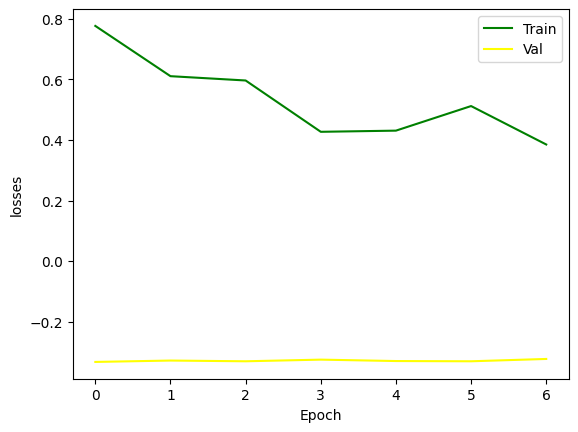

<Figure size 640x480 with 0 Axes>

RuntimeError: [enforce fail at ..\caffe2\serialize\inline_container.cc:325] . unexpected pos 4240192 vs 4240144

In [51]:

best_train_lr = None
best_train_weight_decay = None
best_train_el = None
best_train_dl = None
best_train_d = None
best_train_epoch = None
best_train_loss  = float("infinity")

best_val_lr = None
best_val_weight_decay = None
best_val_el = None
best_val_dl = None
best_val_d = None
best_val_epoch = None
best_val_loss  = float("infinity")

numOfSearch = 10
parameter_pairs = getParameterPairs(numOfSearch)
for lr, weight_decay, el, dl, d in parameter_pairs:
    model = TimeSeriesTransformerForPrediction(getConfig(el, dl, d))
    model, cur_best_train_score, cur_best_train_epoch, cur_best_val_score, cur_best_val_epoch =\
        train(model, train_dataloader, val_dataloader1, 10, lr, weight_decay, el, dl, d)
        
    if cur_best_train_score < best_train_loss:
        best_train_loss = cur_best_train_score
        best_train_epoch = cur_best_train_epoch
        best_train_lr = lr
        best_train_weight_decay = weight_decay
        best_train_el = el
        best_train_dl = dl
        best_train_d = d
        
    if cur_best_val_score < best_val_loss:
        best_val_loss = cur_best_val_score
        best_val_epoch = cur_best_val_epoch
        best_val_lr = lr    
        best_val_weight_decay = weight_decay
        best_val_el = el
        best_val_dl = dl
        best_val_d = d

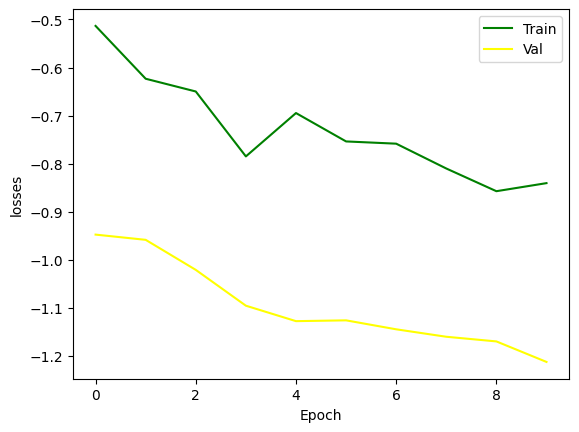

<Figure size 640x480 with 0 Axes>

-------------TRAINING END-------------


In [50]:
# vanilla_model_path = "saved_models/electric/vanilla/0.00015536611996387696-0.0012749726309835014-16-16-64/state/9"
# vanilla_model = TimeSeriesTransformerForPrediction(getConfig(16, 16, 64))
# vanilla_model.load_state_dict(torch.load(vanilla_model_path))
# vanilla_model.eval()


# model, cur_best_train_score, cur_best_train_epoch, cur_best_val_score, cur_best_val_epoch =\
#     train(vanilla_model, train_dataloader, val_dataloader1, 10, lr, weight_decay, el, dl, d)
    
# if cur_best_train_score < best_train_loss:
#     best_train_loss = cur_best_train_score
#     best_train_epoch = cur_best_train_epoch
#     best_train_lr = lr
#     best_train_weight_decay = weight_decay
#     best_train_el = el
#     best_train_dl = dl
#     best_train_d = d
    
# if cur_best_val_score < best_val_loss:
#     best_val_loss = cur_best_val_score
#     best_val_epoch = cur_best_val_epoch
#     best_val_lr = lr    
#     best_val_weight_decay = weight_decay
#     best_val_el = el
#     best_val_dl = dl
#     best_val_d = d
# Continue training

In [52]:
print(f"Out of {numOfSearch} loop, \
    the best training loss is {best_train_loss} at Epoch {best_train_epoch}, with lr:{best_train_lr} \
        wd:{best_train_weight_decay} el:{best_train_el} dl:{best_train_dl} d:{best_train_d}")
print(f"Out of {numOfSearch} loop, \
    the best validation loss is {best_val_loss} at Epoch {best_val_epoch}, with lr:{best_val_lr} \
        wd:{best_val_weight_decay} el:{best_val_el} dl:{best_val_dl} d:{best_val_d}")

with open("best_results.txt", "a") as f:
    f.write(f"Best training loss is {best_train_loss} at Epoch {best_train_epoch}, with lr:{best_train_lr} \
        wd:{best_train_weight_decay} el:{best_train_el} dl:{best_train_dl} d:{best_train_d}\n")
    f.write(f"Best validation loss is {best_val_loss} at Epoch {best_val_epoch}, with lr:{best_val_lr} \
        wd:{best_val_weight_decay} el:{best_val_el} dl:{best_val_dl} d:{best_val_d}\n")

Out of 20 loop,     the best training loss is -1.3685821291804314 at Epoch 14, with lr:0.0012983824357801948         wd:0.0012027909016155336 el:4 dl:4 d:128
Out of 20 loop,     the best validation loss is -1.3774073189496994 at Epoch 12, with lr:0.0012983824357801948         wd:0.0012027909016155336 el:4 dl:4 d:128


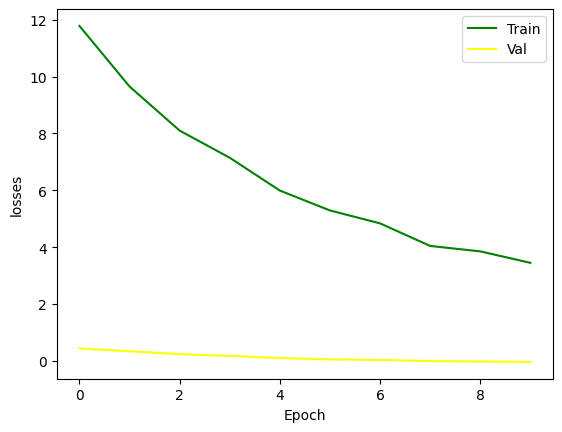

<Figure size 640x480 with 0 Axes>

-------------TRAINING END-------------


In [98]:
# Train autoformer

best_train_lr = None
best_train_weight_decay = None
best_train_el = None
best_train_dl = None
best_train_d = None
best_train_epoch = None
best_train_loss  = float("infinity")

best_val_lr = None
best_val_weight_decay = None
best_val_el = None
best_val_dl = None
best_val_d = None
best_val_epoch = None
best_val_loss  = float("infinity")

numOfSearch = 5
parameter_pairs = getParameterPairs(numOfSearch)
for lr, weight_decay, el, dl, d in parameter_pairs:
    model = AutoformerForPrediction(getAutoformerConfig(el, dl, d))
    AUTOFORMER_PATH = f"saved_models/electric/autoformer/{str(lr)}-{str(weight_decay)}-{str(el)}-{str(dl)}-{str(d)}/"
    model, cur_best_train_score, cur_best_train_epoch, cur_best_val_score, cur_best_val_epoch =\
        train(model, train_dataloader, val_dataloader1, 10, lr, weight_decay, el, dl, d, AUTOFORMER_PATH)
        
    if cur_best_train_score < best_train_loss:
        best_train_loss = cur_best_train_score
        best_train_epoch = cur_best_train_epoch
        best_train_lr = lr
        best_train_weight_decay = weight_decay
        best_train_el = el
        best_train_dl = dl
        best_train_d = d
        
    if cur_best_val_score < best_val_loss:
        best_val_loss = cur_best_val_score
        best_val_epoch = cur_best_val_epoch
        best_val_lr = lr    
        best_val_weight_decay = weight_decay
        best_val_el = el
        best_val_dl = dl
        best_val_d = d
        

In [99]:
print(f"Out of {numOfSearch} loop, \
    the best training loss is {best_train_loss} at Epoch {best_train_epoch}, with lr:{best_train_lr} \
        wd:{best_train_weight_decay} el:{best_train_el} dl:{best_train_dl} d:{best_train_d}")
print(f"Out of {numOfSearch} loop, \
    the best validation loss is {best_val_loss} at Epoch {best_val_epoch}, with lr:{best_val_lr} \
        wd:{best_val_weight_decay} el:{best_val_el} dl:{best_val_dl} d:{best_val_d}")

with open("best_results_autoformer.txt", "a") as f:
    f.write(f"Best training loss is {best_train_loss} at Epoch {best_train_epoch}, with lr:{best_train_lr} \
        wd:{best_train_weight_decay} el:{best_train_el} dl:{best_train_dl} d:{best_train_d}\n")
    f.write(f"Best validation loss is {best_val_loss} at Epoch {best_val_epoch}, with lr:{best_val_lr} \
        wd:{best_val_weight_decay} el:{best_val_el} dl:{best_val_dl} d:{best_val_d}\n")

Out of 5 loop,     the best training loss is -0.4260677340143593 at Epoch 9, with lr:0.001068028594884329         wd:0.007129916820219124 el:4 dl:4 d:64
Out of 5 loop,     the best validation loss is -0.3986750799231231 at Epoch 9, with lr:0.001068028594884329         wd:0.007129916820219124 el:4 dl:4 d:64


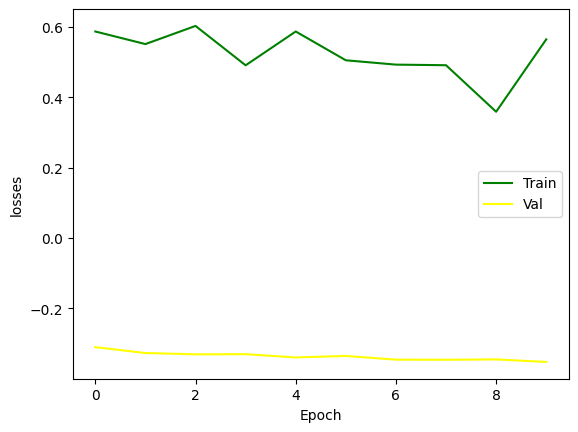

<Figure size 640x480 with 0 Axes>

-------------TRAINING END-------------


In [96]:
# Train informer

best_train_lr = None
best_train_weight_decay = None
best_train_el = None
best_train_dl = None
best_train_d = None
best_train_epoch = None
best_train_loss  = float("infinity")

best_val_lr = None
best_val_weight_decay = None
best_val_el = None
best_val_dl = None
best_val_d = None
best_val_epoch = None
best_val_loss  = float("infinity")

numOfSearch = 10
parameter_pairs = getParameterPairs(numOfSearch)
for lr, weight_decay, el, dl, d in parameter_pairs:
    model = InformerForPrediction(getInformerConfig(el, dl, d))
    INFORMER_PATH = f"saved_models/electric/informer/{str(lr)}-{str(weight_decay)}-{str(el)}-{str(dl)}-{str(d)}/"
    
    model, cur_best_train_score, cur_best_train_epoch, cur_best_val_score, cur_best_val_epoch =\
        train(model, train_dataloader, val_dataloader1, 10, lr, weight_decay, el, dl, d, INFORMER_PATH)
        
    if cur_best_train_score < best_train_loss:
        best_train_loss = cur_best_train_score
        best_train_epoch = cur_best_train_epoch
        best_train_lr = lr
        best_train_weight_decay = weight_decay
        best_train_el = el
        best_train_dl = dl
        best_train_d = d
        
    if cur_best_val_score < best_val_loss:
        best_val_loss = cur_best_val_score
        best_val_epoch = cur_best_val_epoch
        best_val_lr = lr    
        best_val_weight_decay = weight_decay
        best_val_el = el
        best_val_dl = dl
        best_val_d = d
        

In [97]:
print(f"Out of {numOfSearch} loop, \
    the best training loss is {best_train_loss} at Epoch {best_train_epoch}, with lr:{best_train_lr} \
        wd:{best_train_weight_decay} el:{best_train_el} dl:{best_train_dl} d:{best_train_d}")
print(f"Out of {numOfSearch} loop, \
    the best validation loss is {best_val_loss} at Epoch {best_val_epoch}, with lr:{best_val_lr} \
        wd:{best_val_weight_decay} el:{best_val_el} dl:{best_val_dl} d:{best_val_d}")

with open("best_results_informer.txt", "a") as f:
    f.write(f"Best training loss is {best_train_loss} at Epoch {best_train_epoch}, with lr:{best_train_lr} \
        wd:{best_train_weight_decay} el:{best_train_el} dl:{best_train_dl} d:{best_train_d}\n")
    f.write(f"Best validation loss is {best_val_loss} at Epoch {best_val_epoch}, with lr:{best_val_lr} \
        wd:{best_val_weight_decay} el:{best_val_el} dl:{best_val_dl} d:{best_val_d}\n")

Out of 10 loop,     the best training loss is -1.2125950843095779 at Epoch 9, with lr:0.0019479658825035573         wd:0.0007558644442048825 el:8 dl:4 d:128
Out of 10 loop,     the best validation loss is -1.1880968964099885 at Epoch 6, with lr:0.0007908587497020333         wd:0.0002246668442624403 el:4 dl:4 d:128


In [100]:
vanilla_model_path = "saved_models/electric/vanilla/0.0012983824357801948-0.0012027909016155336-4-4-128/state/22"
vanilla_model = TimeSeriesTransformerForPrediction(getConfig(4, 4, 128))
vanilla_model.load_state_dict(torch.load(vanilla_model_path))
vanilla_model.eval()


autoformer_path = "saved_models/electric/autoformer/0.0006177208992754295-0.00010891183568509036-16-8-128/state/8"
autoformer_model = AutoformerForPrediction(getAutoformerConfig(16, 8, 128))
autoformer_model.load_state_dict(torch.load(autoformer_path))
autoformer_model.eval()

informer_path = "saved_models/electric/informer/0.0007908587497020333-0.0002246668442624403-4-4-128/state/6"
informer_model = InformerForPrediction(getInformerConfig(4, 4, 128))
informer_model.load_state_dict(torch.load(informer_path))
informer_model.eval()


InformerForPrediction(
  (model): InformerModel(
    (scaler): InformerStdScaler()
    (embedder): InformerFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(2220, 2)
      )
    )
    (encoder): InformerEncoder(
      (value_embedding): InformerValueEmbedding(
        (value_projection): Linear(in_features=26, out_features=128, bias=False)
      )
      (embed_positions): InformerSinusoidalPositionalEmbedding(21, 128)
      (layers): ModuleList(
        (0): InformerEncoderLayer(
          (self_attn): InformerProbSparseAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivatio

In [101]:
def evaluate(model, data_loader):
    model.eval()
    

    forecasts = []

    for batch in data_loader:
        outputs = model.generate(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
        )
        forecasts.append(outputs.sequences.cpu().numpy())
        
    forecasts = np.vstack(forecasts)
    return forecasts


In [102]:

# forecasts = evaluate(model, test_dataloader)
vanilla_forecasts = evaluate(vanilla_model, test_dataloader)
autoformer_forecasts = evaluate(autoformer_model, test_dataloader)
informer_forecasts = evaluate(informer_model, test_dataloader)


In [103]:
# Transform test dataset's nan values to 0
for item_id, ts in enumerate(test_dataset): 
    for i in range(len(ts["target"])):
        if np.isnan(ts["target"][i]):
            test_dataset[item_id]["target"][i] = 0

In [105]:
from evaluate import load
from helper import CRPS, crps_nrg, crps_pwm
from gluonts.time_feature import get_seasonality
def calculate(forecasts, dataset):

    mse_metric = load("evaluate-metric/mse")
    mase_metric = load("evaluate-metric/mase")
    smape_metric = load("evaluate-metric/smape")

    forecast_median = np.median(forecasts, 1)

    mse_metrics = []
    mase_metrics = []
    smape_metrics = []
    crps_metrics = []
    for item_id, ts in enumerate(dataset):
        training_data = ts["target"][:-prediction_length]
        ground_truth = ts["target"][-prediction_length:]
        mse = mse_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth)
            )
        mse_metrics.append(mse["mse"])
        
        mase = mase_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth), 
            training=np.array(training_data), 
            periodicity=get_seasonality(freq))
        mase_metrics.append(mase["mase"])
        
        smape = smape_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth), 
        )
        smape_metrics.append(smape["smape"])

        crps_metrics.append(crps_pwm(forecast_median[item_id], np.array(ground_truth)))
        
    return mse_metrics, mase_metrics, smape_metrics, crps_metrics


mse_metrics, mase_metrics, smape_metrics, crps_metrics  = calculate(vanilla_forecasts, test_dataset)   
mse_metrics3, mase_metrics3, smape_metrics3, crps_metrics3  = calculate(autoformer_forecasts, test_dataset)   
mse_metrics4, mase_metrics4, smape_metrics4, crps_metrics4  = calculate(informer_forecasts, test_dataset)   
print(f"Vanilla Test MSE: {np.mean(mse_metrics)}")
print(f"Autofromer Test MSE: {np.mean(mse_metrics3)}")
print(f"Informer Test MSE: {np.mean(mse_metrics4)}")
print("===============================================")
print(f"Vanilla Test MASE: {np.mean(mase_metrics)}")
print(f"Autofromer Test MASE: {np.mean(mase_metrics3)}")
print(f"Informer Test MASE: {np.mean(mase_metrics4)}")
print("===============================================")
print(f"Vanilla Test sMAPE: {np.mean(smape_metrics)}")
print(f"Autofromer Test sMAPE: {np.mean(smape_metrics3)}")
print(f"Informer Test sMAPE: {np.mean(smape_metrics4)}")
print("===============================================")
print(f"Vanilla Test crps: {np.mean(crps_metrics)}")
print(f"Autofromer Test crps: {np.mean(crps_metrics3)}")
print(f"Informer Test crps: {np.mean(crps_metrics4)}")  


Vanilla Test MSE: 35.984566186132
Autofromer Test MSE: 98.40168126318416
Informer Test MSE: 3.316408929850261
Vanilla Test MASE: 196831282014893.25
Autofromer Test MASE: 404499461026062.5
Informer Test MASE: 65681212143139.33
Vanilla Test sMAPE: 0.6980404193819565
Autofromer Test sMAPE: 1.4219743113053098
Informer Test sMAPE: 0.7253944334219888
Vanilla Test crps: 0.666652536171046
Autofromer Test crps: 3.1936013749557226
Informer Test crps: 0.30108784860753646


In [96]:
# TODO: Remember to scaler.inverse_transform() 
# for item_id, ts in enumerate(test_dataset): 
    
#     test_dataset[item_id]["target"] = scaler.inverse_transform(test_dataset[item_id]["target"])
# vanilla_forecasts = scaler.inverse_transform(vanilla_forecasts)
# for item_id, vf in enumerate(vanilla_forecasts):
    # print(vanilla_forecasts[item_id])
    # vanilla_forecasts[item_id] = scaler.inverse_transform(vanilla_forecasts[item_id])
    # print(vanilla_forecasts[item_id])

# vanilla_forecasts

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

In [37]:
import matplotlib.dates as mdates
import random 
def plot(ts_index, forecasts, save = False):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.title(str(ts_index) + "-" + str(int(ts_index) + prediction_length))
    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    if save:
        plt.savefig("graph/electric/" + str(ts_index) + "-" + str(int(ts_index) + prediction_length) + ".png")
    plt.legend()
    plt.show()

def plot_randomly(forecasts):
    plot(random.randint(0, len(forecasts) - 1), forecasts)


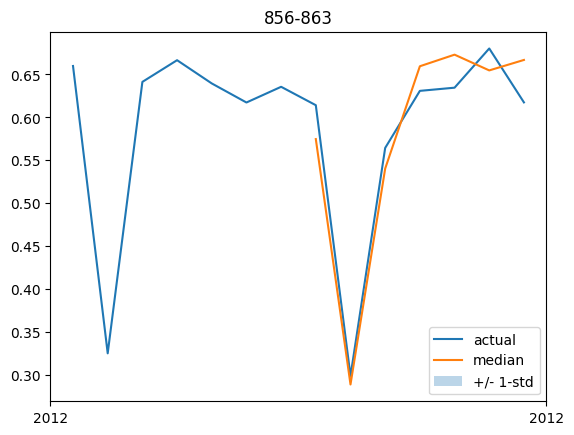

In [42]:
plot_randomly(vanilla_forecasts)


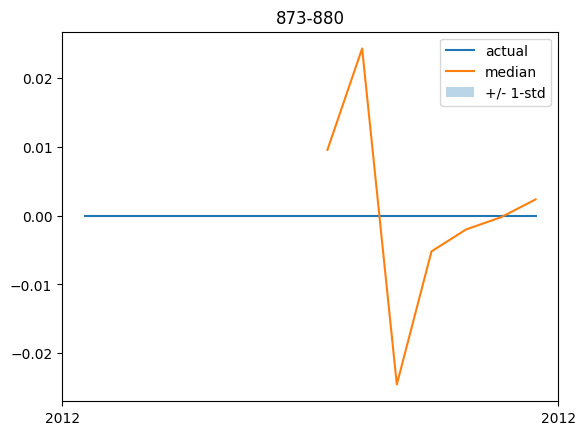

In [92]:
plot_randomly(informer_forecasts)


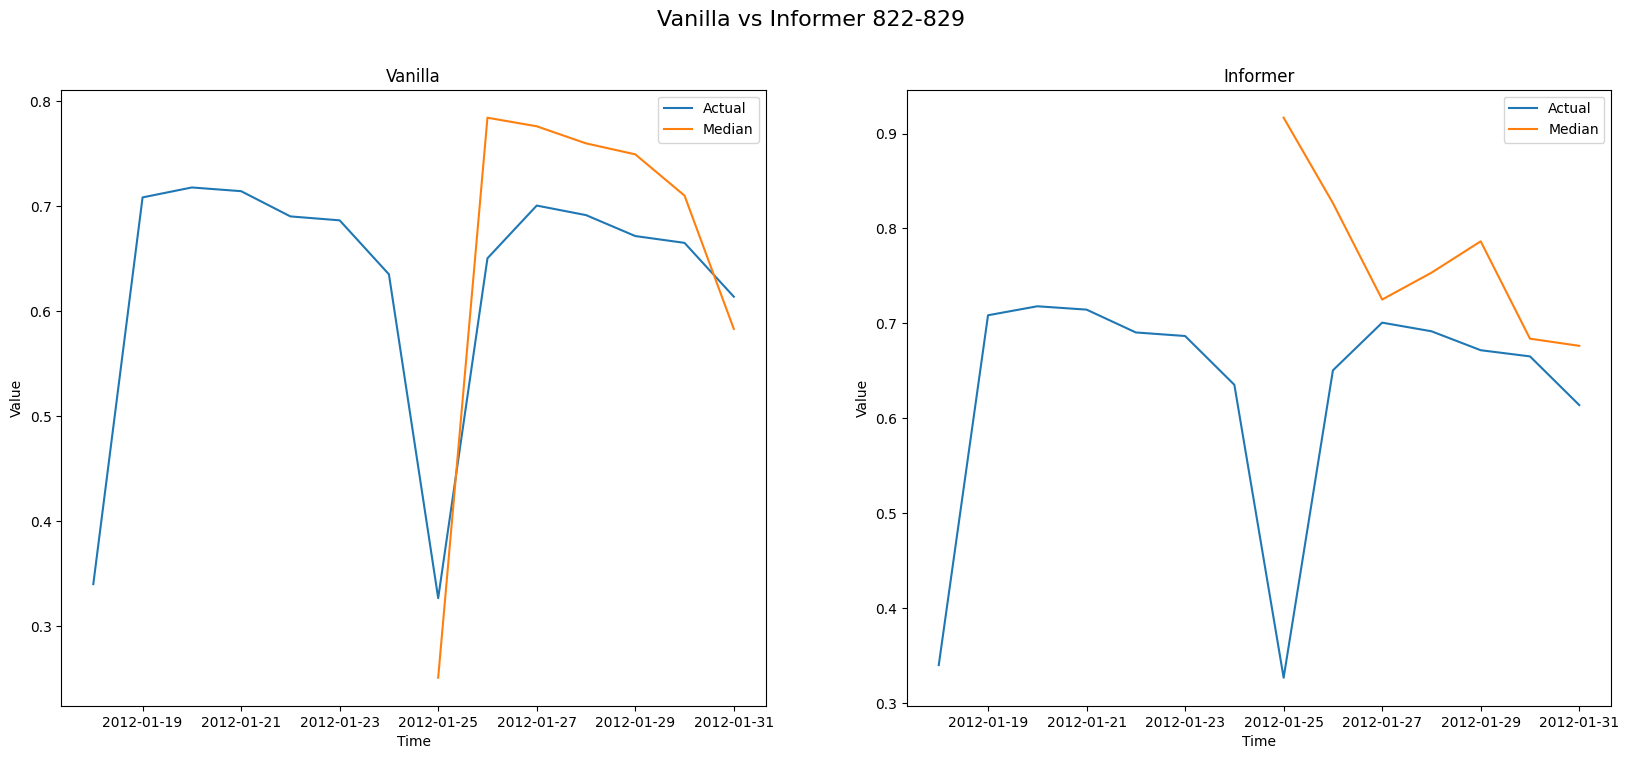

In [93]:

def plot_van_vs_inf(ts_index, vanilla_forecasts, informer_forecasts, save = False):

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    ax1.plot(index[-2*prediction_length:], test_dataset[ts_index]["target"][-2*prediction_length:],  label='Actual')

    ax1.set_title("Vanilla")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Value")
    ax1.plot(index[-prediction_length:], np.median(vanilla_forecasts[ts_index], axis=0), label = "Median")
    ax1.legend()
    

    ax2.plot(index[-2*prediction_length:], test_dataset[ts_index]["target"][-2*prediction_length:],  label='Actual')

    ax2.set_title("Informer")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Value")
    ax2.plot(index[-prediction_length:], np.median(informer_forecasts[ts_index], axis=0), label = "Median")
    ax2.legend()

    if save:
        plt.savefig("graph/electric/compare/" + str(ts_index) + "-" + str(int(ts_index) + prediction_length) + ".png")
        
    fig.suptitle("Vanilla vs Informer " + str(ts_index) + "-" + str(int(ts_index) + prediction_length), fontsize=16)
    
plot_van_vs_inf(822, vanilla_forecasts, informer_forecasts, True)

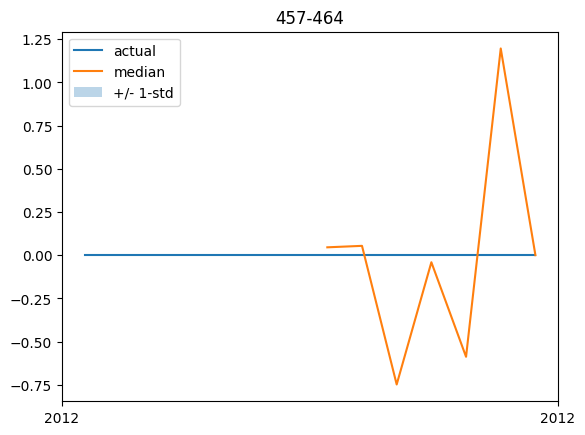

In [35]:
plot_randomly(autoformer_forecasts)


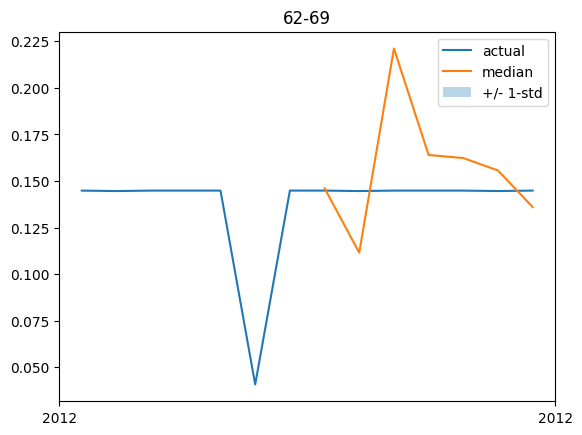

In [ ]:

# # Try with epoch of 20 

# TODO: does the model's parameters reset when I pass it in the training loop again? FIND OUT
model = TimeSeriesTransformerForPrediction(config)
model = train(model, train_dataloader, 10)

-------------TRAINING START-------------
Training with epoch: 10
0.6526011824607849
0.3130802512168884
0.36704644560813904
0.21169684827327728
0.12620525062084198
0.4242374002933502
0.09392771869897842
0.255525678396225
0.14382927119731903
0.0988430455327034
-------------TRAINING END-------------


In [ ]:

forecasts_test = evaluate(model, test_dataloader) 

In [ ]:

train_dataloader_eval = create_test_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=64,
)
forecasts_train = evaluate(model, train_dataloader_eval)

In [ ]:

mse_metrics_train, mase_metrics_train, smape_metrics_train = calculate(forecasts_train, train_dataset)   

In [ ]:

 
mse_metrics_test, mase_metrics_test, smape_metrics_test = calculate(forecasts_test, test_dataset)  
print(f"Test MSE: {np.mean(mse_metrics_test)}")
print(f"Test MASE: {np.mean(mase_metrics_test)}")
print(f"Test sMAPE: {np.mean(smape_metrics_test)}")

Test MSE: 0.14962979146346184
Test MASE: 1.634524162297278
Test sMAPE: 0.3614950069991882


In [ ]:

print(f"Train MSE: {np.mean(mse_metrics_train)}")
print(f"Test MSE: {np.mean(mse_metrics_test)}")
print(f"Train MASE: {np.mean(mase_metrics_train)}")
print(f"Test MASE: {np.mean(mase_metrics_test)}")
print(f"Train sMAPE: {np.mean(smape_metrics_train)}")
print(f"Test sMAPE: {np.mean(smape_metrics_test)}")

Train MSE: 0.1016107306770977
Test MSE: 0.07031509309540471
Train MASE: 0.9560396630533824
Test MASE: 1.1003828219742027
Train sMAPE: 0.27435744239020354
Test sMAPE: 0.23152500989246366


In [ ]:

plot(0, forecasts_train)
plot(prediction_length, forecasts_train)
plot(prediction_length * 2, forecasts_train)
plot(prediction_length * 3, forecasts_train)
plot(prediction_length * 4, forecasts_train)

NameError: name 'forecasts_train' is not defined

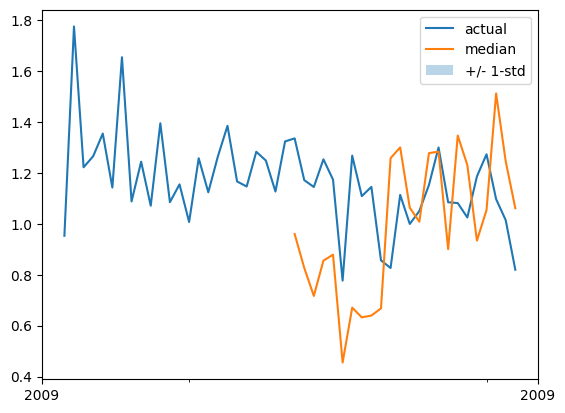

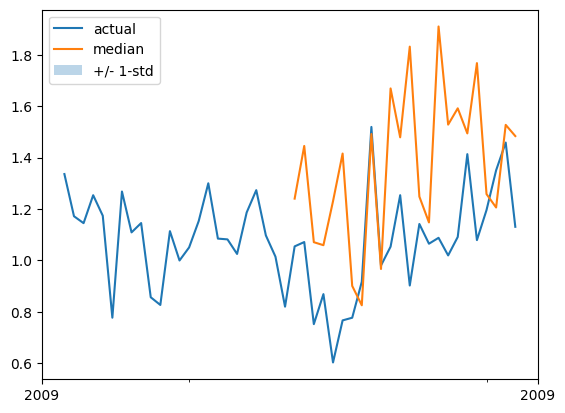

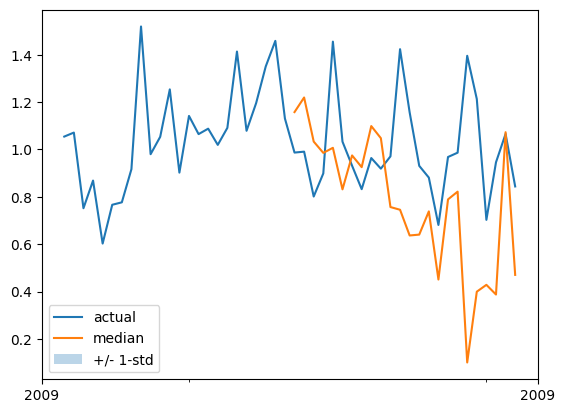

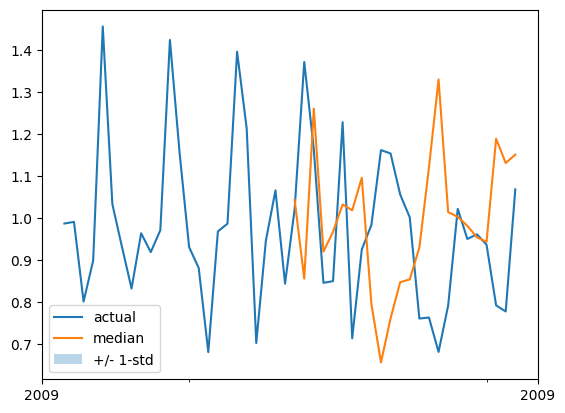

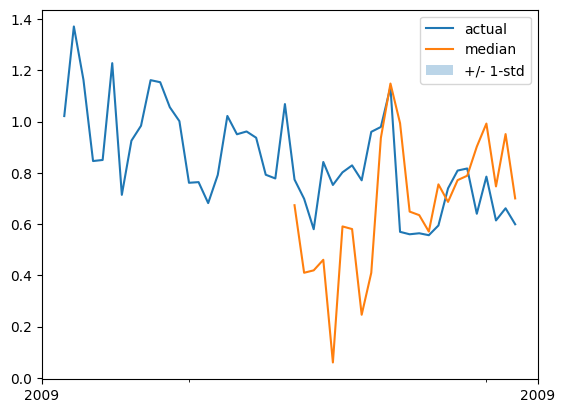

In [ ]:

plot(0, forecasts_test)
plot(prediction_length, forecasts_test)
plot(prediction_length * 2, forecasts_test)
plot(prediction_length * 3, forecasts_test)
plot(prediction_length * 4, forecasts_test)